# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    #x_scaled = StandardScaler().fit_transform(x.values)    
    scaler_obj = StandardScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.head(5)

,tick_avg,spread_avg,tick_sd,sema,lema,sema_diff,lema_diff,diff,avg_gain,avg_loss,...,ssma_diff,lsma,lsma_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,ema_diff,direction
0,1.146260,0.000335,0.000007,1.146314,1.146325,-5.083489e-06,-0.000003,-0.000011,0.000007,0.000012,...,0.000002,1.146350,-0.000003,-0.000033,1.146361,1.146228,0.000101,-0.000032,-0.000011,same
1,1.146310,0.000254,0.000028,1.146315,1.146322,8.506514e-07,-0.000003,0.000050,0.000010,0.000012,...,0.000004,1.146342,-0.000008,-0.000021,1.146361,1.146260,0.000052,-0.000050,-0.000007,same
2,1.146294,0.000307,0.000028,1.146312,1.146318,-2.520140e-06,-0.000003,-0.000015,0.000010,0.000009,...,-0.000002,1.146334,-0.000008,-0.000015,1.146361,1.146260,0.000067,-0.000035,-0.000006,same
3,1.146304,0.000290,0.000020,1.146311,1.146316,-1.216163e-06,-0.000003,0.000010,0.000006,0.000009,...,-0.000002,1.146327,-0.000008,-0.000009,1.146361,1.146260,0.000057,-0.000045,-0.000005,same
4,1.146309,0.000308,0.000016,1.146310,1.146313,-9.745326e-07,-0.000003,0.000004,0.000007,0.000008,...,-0.000003,1.146319,-0.000008,-0.000004,1.146349,1.146260,0.000040,-0.000049,-0.000003,same


In [4]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 49948
--------------------------
same        26946
increase    11545
decrease    11457
Name: direction, dtype: int64
--------------------------
same        0.539481
increase    0.231140
decrease    0.229379
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [6]:
model = Sequential([
    Dense(units = 256, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 512, activation='relu'),
    Dense(units = 1024, activation='relu'),
    Dense(units = 32, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5888      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 695,683
Trainable params: 695,683
Non-trainable params: 0
_________________________________________________________________


### Training

In [7]:
epoch_val         = 20
batch_size_val    = 512

verbose_val       = 2
workers_val       = -1

In [8]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/20
79/79 - 0s - loss: 0.6313 - accuracy: 0.7563 - val_loss: 0.4482 - val_accuracy: 0.8102
Epoch 2/20
79/79 - 0s - loss: 0.4152 - accuracy: 0.8221 - val_loss: 0.4107 - val_accuracy: 0.8253
Epoch 3/20
79/79 - 0s - loss: 0.3904 - accuracy: 0.8337 - val_loss: 0.3958 - val_accuracy: 0.8307
Epoch 4/20
79/79 - 0s - loss: 0.3806 - accuracy: 0.8379 - val_loss: 0.3880 - val_accuracy: 0.8360
Epoch 5/20
79/79 - 0s - loss: 0.3714 - accuracy: 0.8420 - val_loss: 0.3846 - val_accuracy: 0.8350
Epoch 6/20
79/79 - 0s - loss: 0.3668 - accuracy: 0.8421 - val_loss: 0.3854 - val_accuracy: 0.8349
Epoch 7/20
79/79 - 0s - loss: 0.3645 - accuracy: 0.8436 - val_loss: 0.3848 - val_accuracy: 0.8368
Epoch 8/20
79/79 - 0s - loss: 0.3645 - accuracy: 0.8438 - val_loss: 0.3796 - val_accuracy: 0.8391
Epoch 9/20
79/79 - 0s - loss: 0.3603 - accuracy: 0.8475 - val_loss: 0.3797 - val_accuracy: 0.8374
Epoch 10/20
79/79 - 0s - loss: 0.3587 - accuracy: 0.8454 - val_loss: 0.3935 - val_accuracy: 0.8288
Epoch 11/20
79/79 -

### DNN Validation

In [9]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.82      0.83      0.83      2310
    increase       0.83      0.83      0.83      2317
        same       0.85      0.85      0.85      5363

    accuracy                           0.84      9990
   macro avg       0.83      0.84      0.83      9990
weighted avg       0.84      0.84      0.84      9990



In [10]:
model.save('data/model/model.h5') 
model_new = load_model('data/model/model.h5')

### DNN Prediction

Record count : 49948
--------------------------
same        20861
increase    14684
decrease    14403
Name: direction, dtype: int64
--------------------------
same        0.417654
increase    0.293986
decrease    0.288360
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.90      0.73      0.80     14403
    increase       0.92      0.70      0.79     14684
        same       0.69      0.90      0.78     20861

    accuracy                           0.79     49948
   macro avg       0.84      0.78      0.79     49948
weighted avg       0.82      0.79      0.79     49948



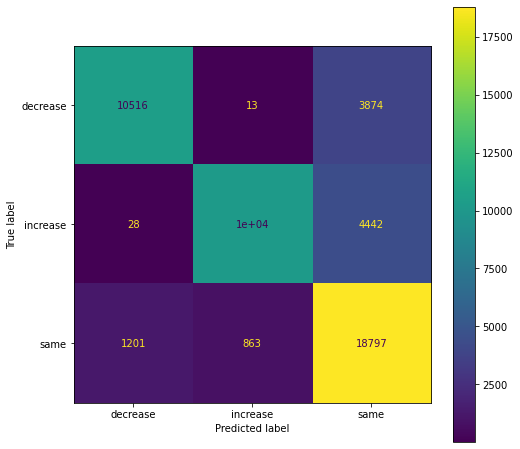

In [11]:
df1 = pd.read_csv('data/tab_tick_2018.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

## RF Results

%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

live_df = pd.read_csv('data/live_preds.csv')
del live_df['predicted_direction']

model_new = load_model('data/model/model.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = scaler_obj.transform(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

predictions = model_new.predict(x_scaled)
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

live_df['predictions'].value_counts()